# Testing aerobulk-python performance

In the following notebook I will investigate:
1. How the computation time scales with the number of time iterations.
2. How the order of dimensions (e.g. longest to shortest or vice versa) influences the exection time of aerobulk python
3. How the execution time scales with values of `niter`
<!-- 4. How the skin correction influences execution time.
5. What is the lowest value of `niter` that provides sufficiently converged values of surface fluxes.
 -->

All test will be carried out with the numpy wrapper, and not involve dask at all.

I developed this on the large pangeo deployment (32GB? Ram and 8 cores).

In [1]:
# You need to run this each time when your notebook server was closed (e.g. when you logged out)
# !mamba install aerobulk-python -y

In [2]:
# Check version
import aerobulk
print(aerobulk.__version__)

0.2.3


In [3]:
import time
import xarray as xr
import numpy as np
from aerobulk import flux_noskin
import itertools
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina'

In [4]:
# A function to generate test data for 1./2./3. 
# In the future we can just import this from aerobulk-python, 
# when this is merged:https://github.com/xgcm/aerobulk-python/pull/15/files
import numpy as np
from typing import Dict
def create_data(shape: tuple, chunks: Dict[str, int] = {}):
    def _arr(value):
        order = "F"  # Does this matter for the results?
        # order = None
        arr = xr.DataArray(np.full(shape, value, order=order))

        # adds random noise scaled by a percentage of the value
        randomize_factor = 0.001
        randomize_range = value * randomize_factor
        arr = arr + np.random.rand(*shape) + randomize_range

        if chunks:
            arr = arr.chunk(chunks)
        return arr

    sst = _arr(290.0)
    t_zt = _arr(280.0)
    hum_zt = _arr(0.001)
    u_zu = _arr(1.0)
    v_zu = _arr(-1.0)
    slp = _arr(101000.0)
    return sst, t_zt, hum_zt, u_zu, v_zu, slp

# Investigate execution time dependence of various parameters
## 1. Execution time based on length of iterdimension

In [81]:
nt_list = np.array([1,2,3,5, 10, 25, 50])

time_list = []
time_std_list = []
for nt in nt_list:
    shape = (300, 150, nt)
    time_sub = []
    for repeat in range(1): # there was really no deviation between these
        test_data = create_data(shape)
        tic = time.time()
        flux_noskin(*test_data, niter=1)
        toc = time.time() - tic
        time_sub.append(toc)
    time_sub = np.array(time_sub)
    time_average = np.mean(time_sub)
    time_std = np.std(time_sub)
    
    time_list.append(time_average)
    time_std_list.append(time_std)

def _relative(in_list, ref):
    return [a/ref for a in in_list]

relative_execution_time = np.array(_relative(time_list, time_list[0]))
relative_execution_std = np.array(_relative(time_std_list, time_list[0]))
time_length = np.array(nt_list)

 
                    ----- AeroBulk_init -----
 
     *** Bulk parameterization to be used => "coare3p0"
     *** Cool-skin & Warm-layer schemes will NOT be used!
     *** Computational domain shape: Ni x Nj = 00300 x 00150
     *** Number of time records that will be treated:           1
     *** Number of iterations in bulk algos: nb_iter  =    1
     *** Filling the `mask` array...
         ==> no points need to be masked! :)
     *** Type of prescribed air humidity  `relative humidity [%]`
                    ----- AeroBulk_bye -----
 
 
                    ----- AeroBulk_init -----
 
     *** Bulk parameterization to be used => "coare3p0"
     *** Cool-skin & Warm-layer schemes will NOT be used!
     *** Computational domain shape: Ni x Nj = 00300 x 00150
     *** Number of time records that will be treated:           2
     *** Number of iterations in bulk algos: nb_iter  =    1
     *** Filling the `mask` array...
         ==> no points need to be masked! :)
     *** Type of pr

Text(0.5, 1.0, "Scaling of compute time for changing time iterations\nwith (300, 150, 'time') array")

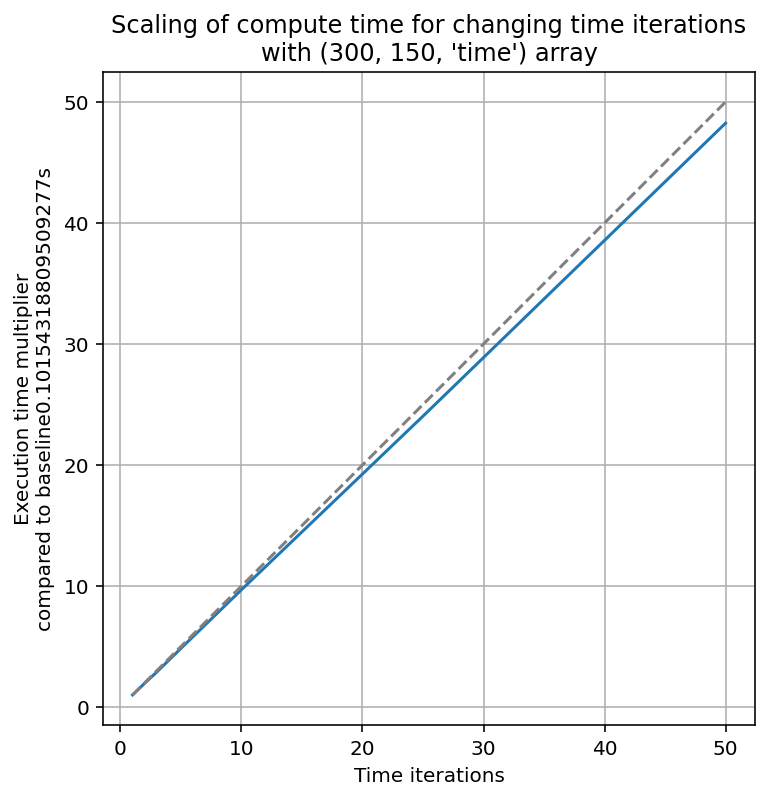

In [82]:
plt.plot(time_length, relative_execution_time)
plt.plot(time_length, time_length, color='0.5', ls='--')
plt.ylabel(f'Execution time multiplier\ncompared to baseline{time_list[0]}s')
plt.xlabel(f'Time iterations')
plt.grid()
plt.gca().set_aspect(1)
plt.title(f"Scaling of compute time for changing time iterations\nwith {(shape[0], shape[1], 'time')} array")

- There seems to be almost no overhead for the init! This is good news for our chunking structure!
- Slightly lower slope than 1, meaning that there is a slight advantage for processing larger chunks, but not much.

## 2. Execution time based on input shape

In [83]:
shape_list = list(itertools.permutations((10000, 100, 1)))+list(itertools.permutations((1000, 1000, 1)))

time_list = []
time_std_list = []
for shape in shape_list:
    time_sub = []
    for repeat in range(10):
        test_data = create_data(shape)
        tic = time.time()
        flux_noskin(*test_data, niter=1)
        toc = time.time() - tic
        time_sub.append(toc)
    time_sub = np.array(time_sub)
    time_average = np.mean(time_sub)
    time_std = np.std(time_sub)
    
    time_list.append(time_average)
    time_std_list.append(time_std)
    

# sort by execution time
time_list_sorted, time_std_list_sorted, shape_list_sorted = zip(*sorted(zip(time_list, time_std_list, shape_list)))

#normalize execution time
tmin = min(time_list)
normalized_time = [(t-tmin)/tmin for t in time_list_sorted]
normalized_std = [t/tmin for t in time_std_list_sorted]

normalized_std = np.array(normalized_std)
normalized_time = np.array(normalized_time)

 
                    ----- AeroBulk_init -----
 
     *** Bulk parameterization to be used => "coare3p0"
     *** Cool-skin & Warm-layer schemes will NOT be used!
     *** Computational domain shape: Ni x Nj = 10000 x 00100
     *** Number of time records that will be treated:           1
     *** Number of iterations in bulk algos: nb_iter  =    1
     *** Filling the `mask` array...
         ==> no points need to be masked! :)
     *** Type of prescribed air humidity  `relative humidity [%]`
                    ----- AeroBulk_bye -----
 
 
                    ----- AeroBulk_init -----
 
     *** Bulk parameterization to be used => "coare3p0"
     *** Cool-skin & Warm-layer schemes will NOT be used!
     *** Computational domain shape: Ni x Nj = 10000 x 00100
     *** Number of time records that will be treated:           1
     *** Number of iterations in bulk algos: nb_iter  =    1
     *** Filling the `mask` array...
         ==> no points need to be masked! :)
     *** Type of pr

Yeah those print statments are quite annoying...😤. We should work on https://github.com/xgcm/aerobulk-python/issues/24

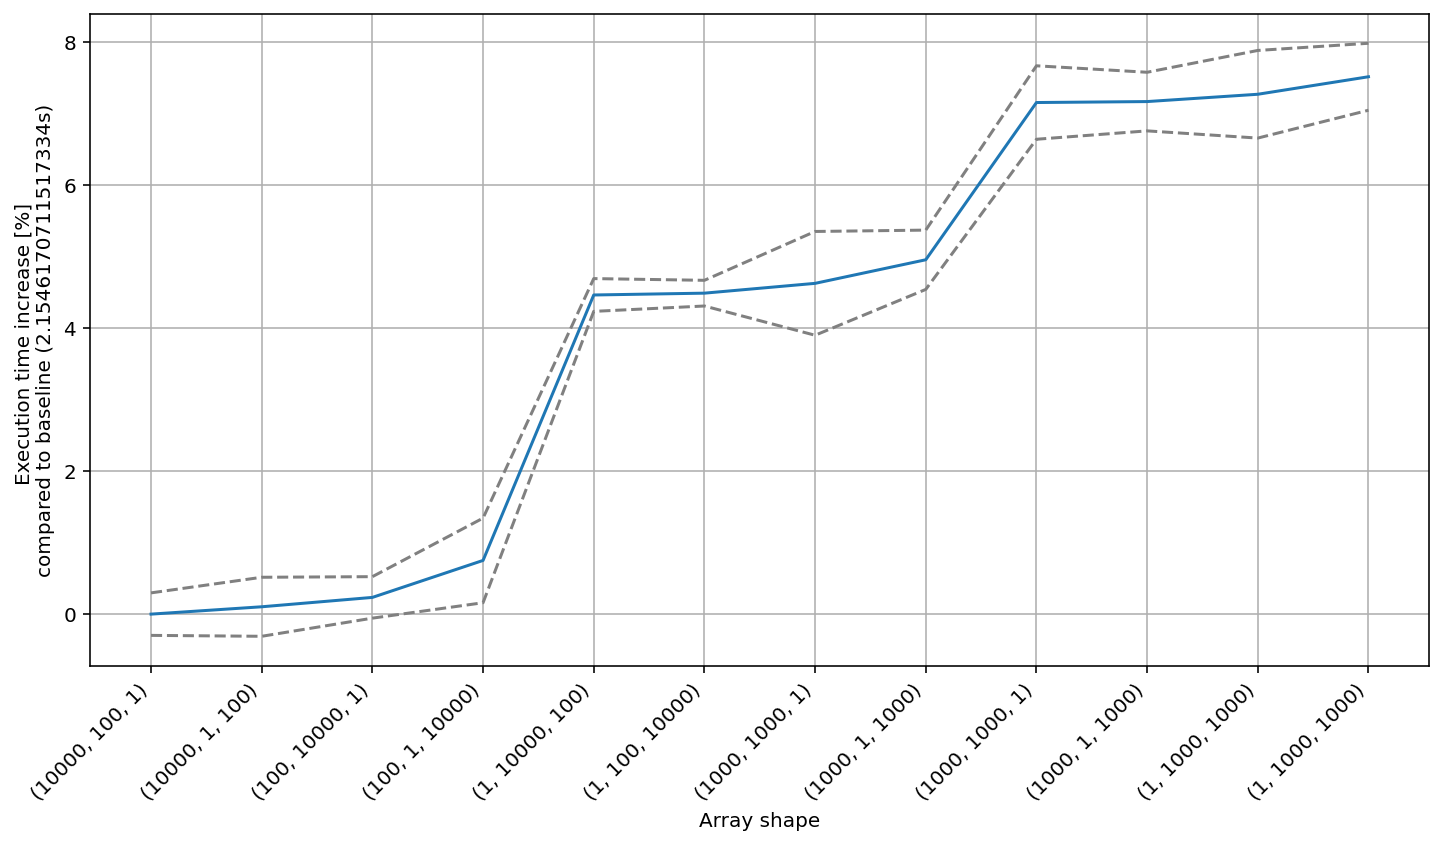

In [84]:
plt.plot(normalized_time*100)
plt.plot((normalized_time+normalized_std)*100, ls='--', color='0.5')
plt.plot((normalized_time-normalized_std)*100, ls='--', color='0.5')
plt.ylabel(f'Execution time increase [%] \ncompared to baseline ({tmin}s)')
plt.xticks(ticks = range(len(normalized_time)), labels=shape_list, ha='right', rotation=45)
plt.xlabel('Array shape')
plt.grid()

**Conclusions**
- I do not really understand these results TBH. I would have expected all shapes that have the smallest number last to be fastest.
- It seems to matter more if the x/y shape is elongated vs square
- Overall it seems like the shape does not matter that much (few percent of execution time). Certainly not something we have to worry about as a immediate priority. 

## 3. How does the execution time scales with values of `niter`

In [95]:
niter_list = np.arange(1,20)
shape = (700, 100, 1)

time_list = []
time_std_list = []
for niter in niter_list:
    time_sub = []
    for repeat in range(1): # there was really no deviation between these
        test_data = create_data(shape)
        tic = time.time()
        flux_noskin(*test_data, niter=niter)
        toc = time.time() - tic
        time_sub.append(toc)
    time_sub = np.array(time_sub)
    time_average = np.mean(time_sub)
    time_std = np.std(time_sub)
    
    time_list.append(time_average)
    time_std_list.append(time_std)

def _relative(in_list, ref):
    return [a/ref for a in in_list]


relative_execution_time = np.array(_relative(time_list, time_list[0]))
relative_execution_std = np.array(_relative(time_std_list, time_list[0]))
iteration_length = np.array(niter_list)

 
                    ----- AeroBulk_init -----
 
     *** Bulk parameterization to be used => "coare3p0"
     *** Cool-skin & Warm-layer schemes will NOT be used!
     *** Computational domain shape: Ni x Nj = 00700 x 00100
     *** Number of time records that will be treated:           1
     *** Number of iterations in bulk algos: nb_iter  =    1
     *** Filling the `mask` array...
         ==> no points need to be masked! :)
     *** Type of prescribed air humidity  `relative humidity [%]`
                    ----- AeroBulk_bye -----
 
 
                    ----- AeroBulk_init -----
 
     *** Bulk parameterization to be used => "coare3p0"
     *** Cool-skin & Warm-layer schemes will NOT be used!
     *** Computational domain shape: Ni x Nj = 00700 x 00100
     *** Number of time records that will be treated:           1
     *** Number of iterations in bulk algos: nb_iter  =    2
     *** Filling the `mask` array...
         ==> no points need to be masked! :)
     *** Type of pr

Text(0.5, 1.0, 'Scaling of compute time for changing algorithm iterations\nwith (700, 100, 1) array')

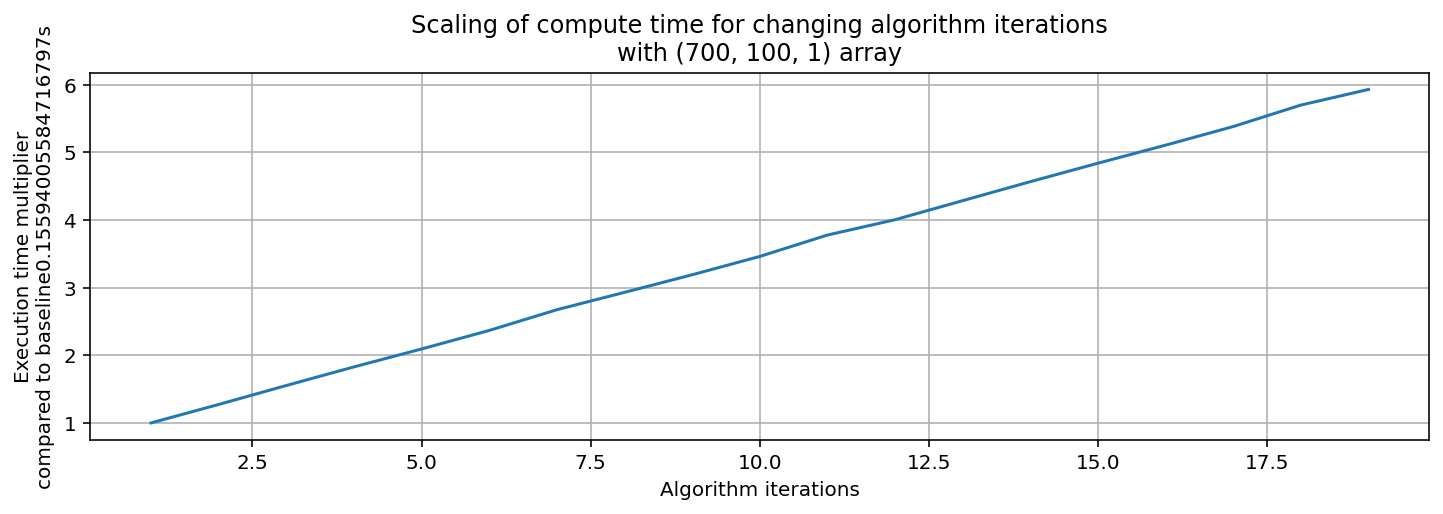

In [96]:
plt.plot(iteration_length, relative_execution_time)
# plt.plot(iteration_length, iteration_length, color='0.5', ls='--')
plt.ylabel(f'Execution time multiplier\ncompared to baseline{time_list[0]}s')
plt.xlabel(f'Algorithm iterations')
plt.grid()
plt.gca().set_aspect(1)
plt.title(f"Scaling of compute time for changing algorithm iterations\nwith {(shape[0], shape[1], shape[2])} array")

# Optimizing `niter`

Lets start to get a feel for how the 'convergence' looks for a single synthetic datapoint

In [5]:
niter_list = np.arange(1,9)
out_vars = ('ql', 'qh', 'taux', 'tauy', 'evap')
algos = ['coare3p0', 'coare3p6', 'andreas', 'ecmwf', 'ncar']

test_data = create_data((1, 1, 1))

output = {algo:{va:[] for va in out_vars} for algo in algos}
for algo in algos:
    for niter in niter_list:
        out = flux_noskin(*test_data, niter=niter, algo=algo)
        single_output = {va:data for va,data in zip(out_vars,out)}
        #populate the main output dict
        for va in out_vars:
            output[algo][va].append(np.atleast_1d(single_output[va].squeeze()))

for algo in algos:
    for va in out_vars:
        output[algo][va] = np.concatenate(output[algo][va])

 
                    ----- AeroBulk_init -----
 
     *** Bulk parameterization to be used => "coare3p0"
     *** Cool-skin & Warm-layer schemes will NOT be used!
     *** Computational domain shape: Ni x Nj = 00001 x 00001
     *** Number of time records that will be treated:           1
     *** Number of iterations in bulk algos: nb_iter  =    1
     *** Filling the `mask` array...
         ==> no points need to be masked! :)
     *** Type of prescribed air humidity  `relative humidity [%]`
                    ----- AeroBulk_bye -----
 
 
                    ----- AeroBulk_init -----
 
     *** Bulk parameterization to be used => "coare3p0"
     *** Cool-skin & Warm-layer schemes will NOT be used!
     *** Computational domain shape: Ni x Nj = 00001 x 00001
     *** Number of time records that will be treated:           1
     *** Number of iterations in bulk algos: nb_iter  =    2
     *** Filling the `mask` array...
         ==> no points need to be masked! :)
     *** Type of pr

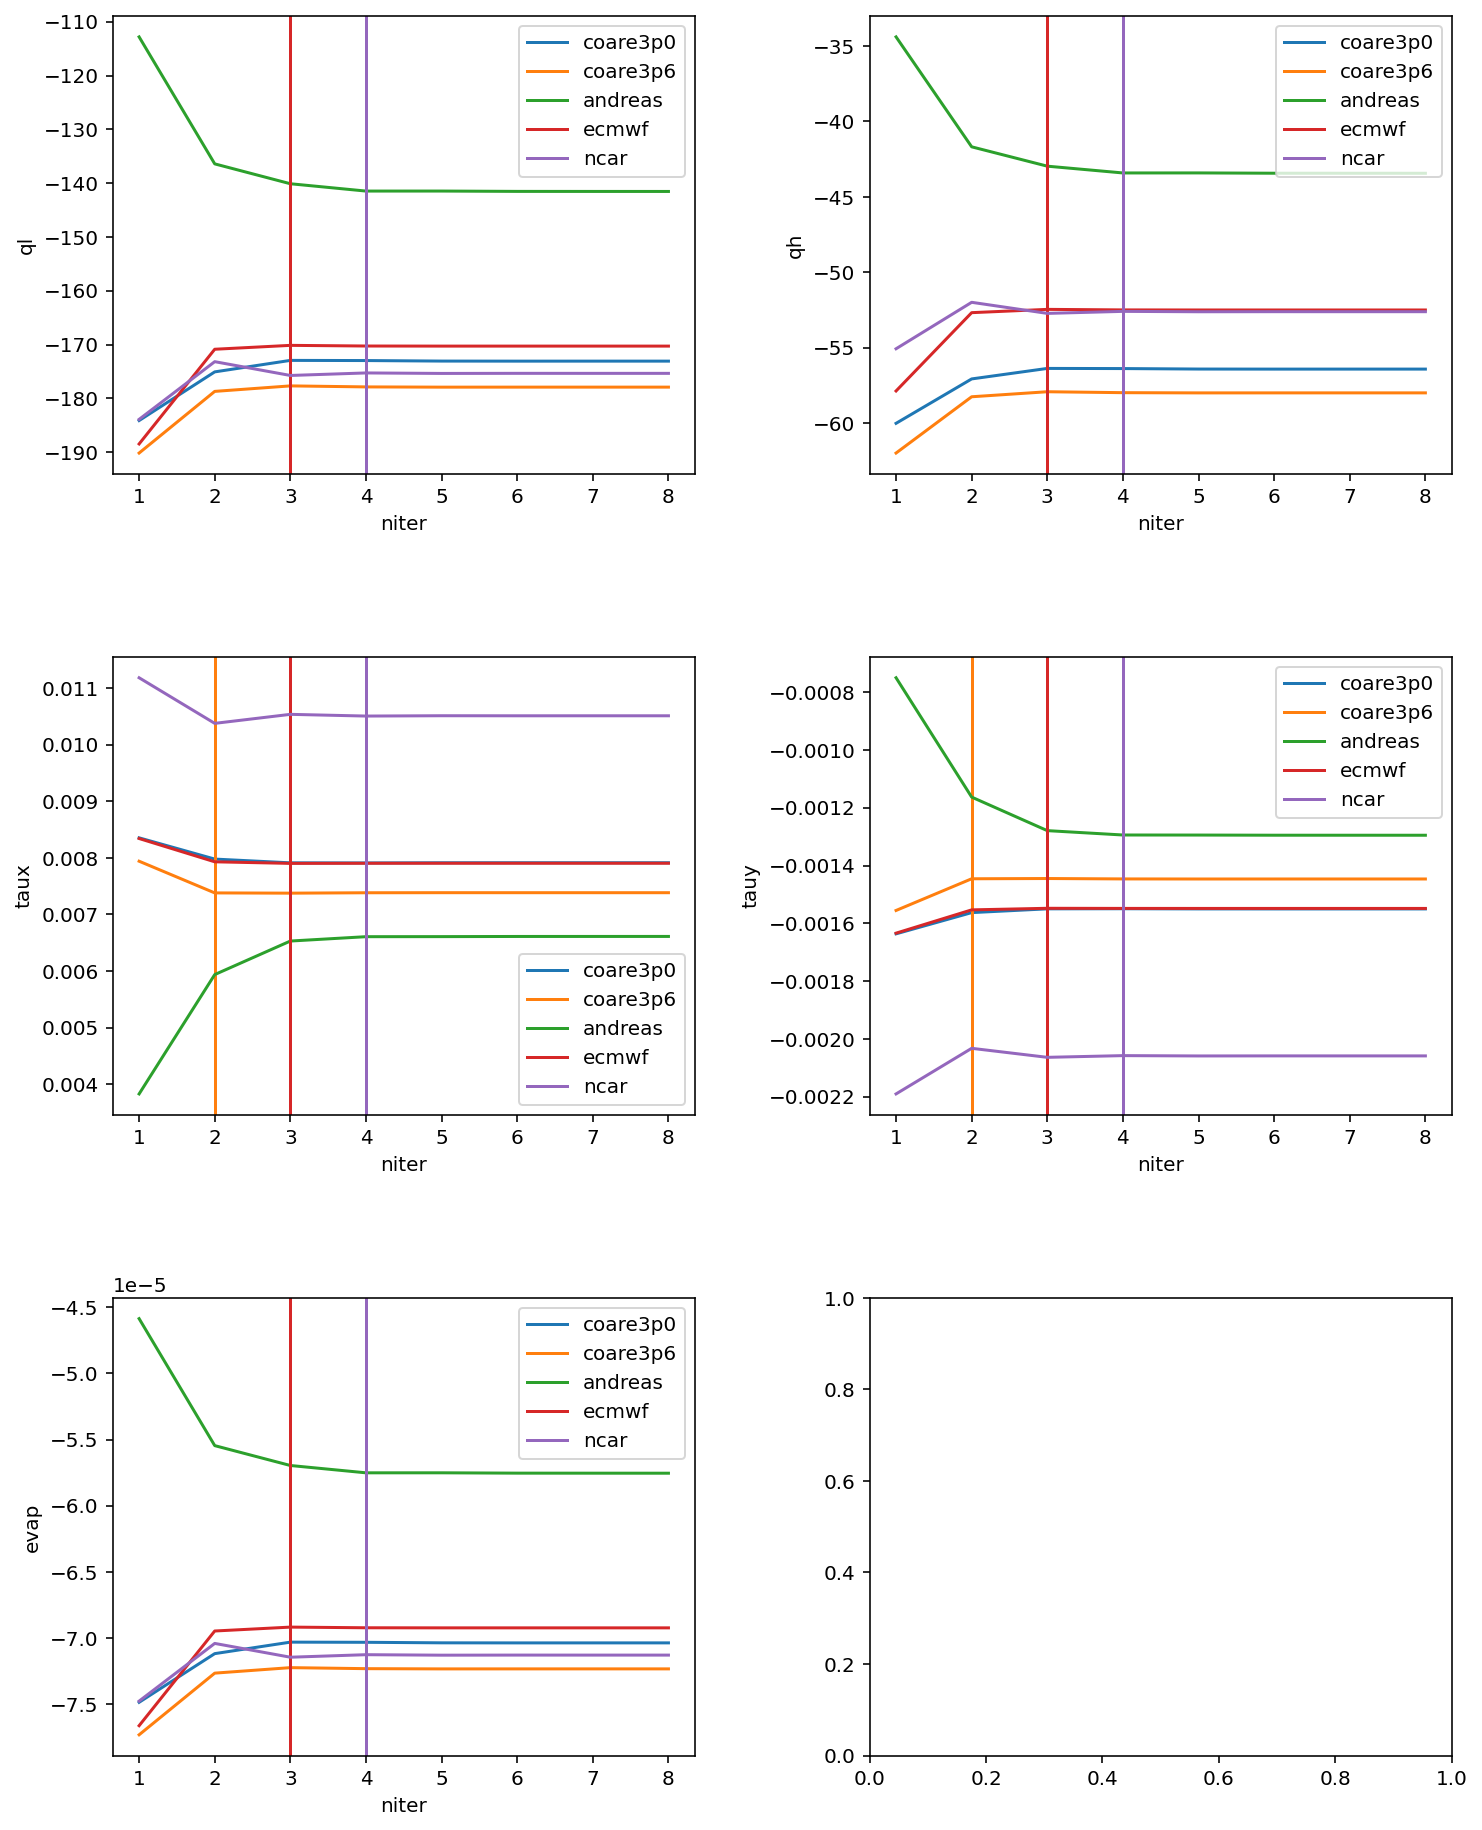

In [6]:
relative_error_threshold = 2e-3

fig, axarr = plt.subplots(ncols=2, nrows=3, figsize=[12,16])
for ai, algo in enumerate(algos):
    algo_color = f"C{ai}"
    for va, ax in zip(out_vars, axarr.flat):
        data = output[algo][va]
        # determine the location where the relative difference is lower than the threshold
        diff = np.diff(data)
        rel_diff = abs(diff/data[-1])
        idx = np.argmax(rel_diff<relative_error_threshold)
        # since we are looking 'one ahead' with this indexing we always need to add another iteration
        idx += 1
        ax.plot(niter_list, data, color=algo_color, label=algo)
        ax.axvline(idx, color=algo_color)
        ax.set_ylabel(va)
        ax.set_xlabel('niter')
        ax.legend()
    fig.subplots_adjust(hspace=0.4, wspace=0.3)

For a single point the selection criteria of 'having a relative error smaller than 0.1% of the initial guess' seems to work well over all variables and algos (we could go with 0.2%, but in the ncar algo that seems not quite 'converged).  
This suggests that a value of `niter=4` is optimal here. 
> TODO: Should we define this per algo? Lets wait for the results below

Now we have to see if this holds on a realistic datasets with a much larger range of values!

### Testing convergence on global model output

In [7]:
## manually recreate the wrapper. This wont be necessary after the PR is merged
def flux_noskin_xr(
    sst, t_zt, hum_zt, u_zu, v_zu, slp=101000.0, algo="coare3p0", zt=10, zu=2, niter=1
):
    # TODO do we need to make the "time" dimension special?

    sst, t_zt, hum_zt, u_zu, v_zu, slp = xr.broadcast(
        sst, t_zt, hum_zt, u_zu, v_zu, slp
    )

    if len(sst.dims) < 3:
        # TODO promote using expand_dims?
        raise NotImplementedError
    if len(sst.dims) > 4:
        # TODO iterate over extra dims? Or reshape?
        raise NotImplementedError

    out_vars = xr.apply_ufunc(
        flux_noskin,
        sst,
        t_zt,
        hum_zt,
        u_zu,
        v_zu,
        slp,
        input_core_dims=[()] * 6,
        output_core_dims=[()] * 5,
        # input_core_dims=[("dim_0", "dim_1", "dim_2")] * 6,
        # output_core_dims=[("dim_0", "dim_1", "dim_2")] * 5,
        dask="parallelized",
        kwargs=dict(
            algo=algo,
            zt=zt,
            zu=zu,
            niter=niter,
        ),
        output_dtypes=[sst.dtype]
        * 5,  # deactivates the 1 element check which aerobulk does not like
    )

    if not isinstance(out_vars, tuple) or len(out_vars) != 5:
        raise TypeError("F2Py returned unexpected types")

    if any(var.ndim != 3 for var in out_vars):
        raise ValueError(
            f"f2py returned result of unexpected shape. Got {[var.shape for var in out_vars]}"
        )

    # TODO if dimensions promoted squeeze them out before returning

    return out_vars  # currently returns only 3D arrays

In [8]:
# Load CM2.6 data
import fsspec
import xesmf as xe
import os
from intake import open_catalog
kwargs = dict(consolidated=True, use_cftime=True)
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/GFDL_CM2.6.yaml")
ds_ocean  = cat["GFDL_CM2_6_control_ocean_surface"].to_dask()
ds_flux  = cat["GFDL_CM2_6_control_ocean_boundary_flux"].to_dask()
ds_atmos = xr.open_zarr('gs://cmip6/GFDL_CM2_6/control/atmos_daily.zarr', **kwargs)
ds_oc_grid  = cat["GFDL_CM2_6_grid"].to_dask()
# cut to same time
all_dims = set(list(ds_ocean.dims)+list(ds_atmos.dims))
ds_ocean, ds_atmos = xr.align(
    ds_ocean,
    ds_atmos,
    join='inner',
    exclude=(di for di in all_dims if di !='time')
)

# for testing, rechunk everything to single time steps
ds_ocean = ds_ocean.chunk({'time':1})
ds_atmos = ds_atmos.chunk({'time':1})
ds_flux = ds_flux.chunk({'time':1})

# Load regridding weights and regrid all fields onto ocean grid
PANGEO_SCRATCH = os.environ['PANGEO_SCRATCH']
# From `upload_cm26_weights_from_gyre.ipynb`
mapper = fsspec.get_mapper(f'{PANGEO_SCRATCH}/jbusecke/test_cm26_xesmf_weights_cloud.zarr')
ds_regridder = xr.open_zarr(mapper)#.persist()

regridder = xe.Regridder(
    ds_atmos.olr.isel(time=0),
    ds_ocean.surface_temp.isel(time=0),
    'bilinear',
    weights=ds_regridder,
    periodic=True
)
regridder

ds_atmos_regridded = regridder(ds_atmos[['slp', 'v_ref', 'u_ref', 't_ref', 'q_ref', 'swdn_sfc', 'lwdn_sfc']])
ds_atmos_regridded

## combine into merged dataset
ds_merged = xr.merge(
    [
        ds_atmos_regridded,
        ds_ocean[['surface_temp']],
    ]
)
ds_merged

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/array/core.py:456: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


<xarray.Dataset>
Dimensions:       (yt_ocean: 2700, xt_ocean: 3600, time: 7305)
Coordinates:
  * yt_ocean      (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * xt_ocean      (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * time          (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    swdn_sfc      (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    lwdn_sfc      (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [9]:
# remove all values over land (this crashes everything....grrrr)
# ds_merged = ds_merged.where(~np.isnan(ds_merged.surface_temp)).fillna(0)

In [10]:
# TODO: run this with dask to get global fields...Currently blows out the memory of even the largest server
from dask.diagnostics import ProgressBar
with ProgressBar():
    ds_test = ds_merged.isel(
        # time=np.arange(0, 180, 30),# one daily value for each month of half a year
        time=[0,180],# two daily values half a year apart
        xt_ocean=slice(400, 1000),
        yt_ocean=slice(1000, 2100)
    ).transpose(
        'xt_ocean', 'yt_ocean', 'time'
    ).load()

[########################################] | 100% Completed |  9.3s


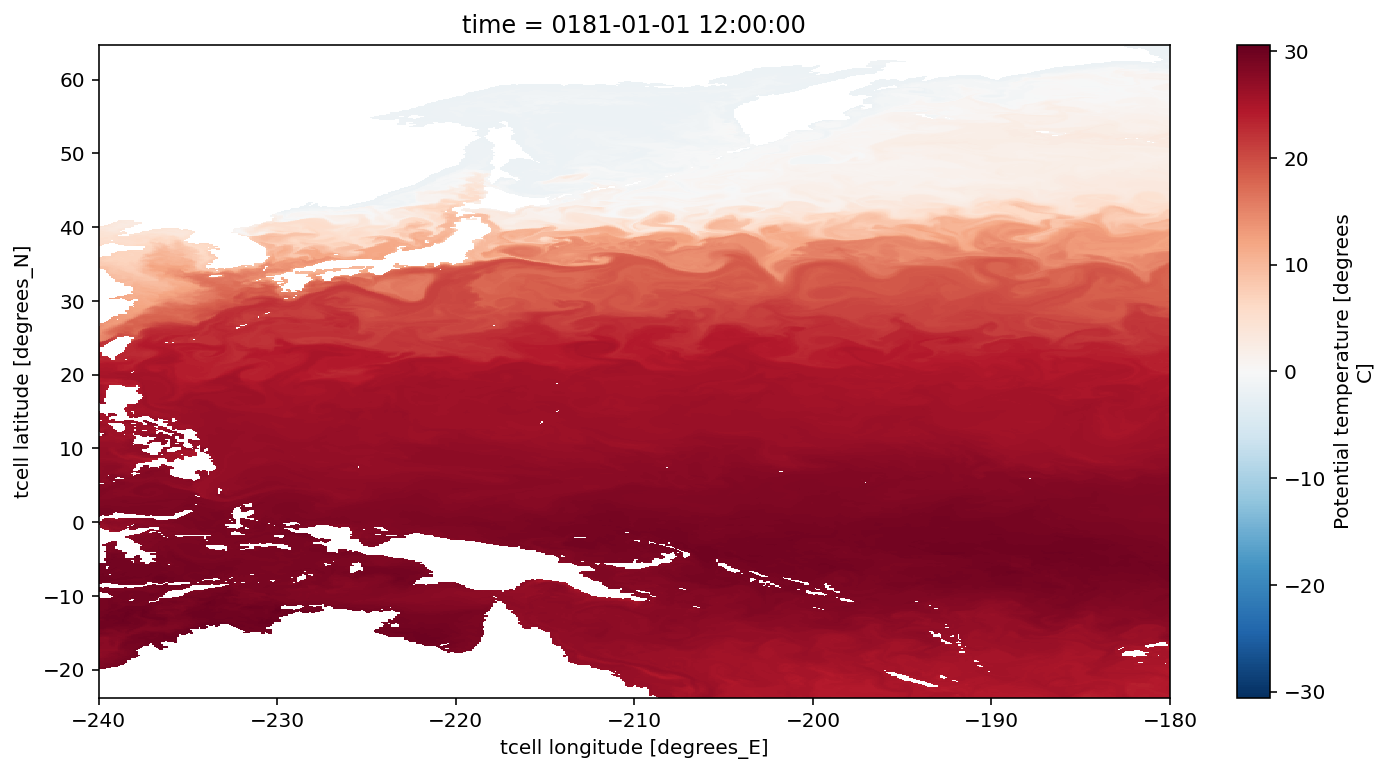

In [11]:
ds_test.surface_temp.isel(time=0).plot(x='xt_ocean')

In [12]:
ds_test.nbytes/1e6

42.253616

In [13]:
outputs = []
niter_list = list(range(1,9))

# algos_filtered = [algo for algo in algos if '6' not in algo] #TODO: Check what is going wrong with coare3p6
# algos_filtered = ['coare3p6'] #quicker version for testing
# for algo in algos_filtered:
for algo in algos:
    print(algo)
    algo_outputs = []
    for niter in niter_list:
        out = flux_noskin_xr(
            ds_test['surface_temp']+ 273.15,
            ds_test['t_ref'],
            ds_test['q_ref'],
            ds_test['u_ref'],
            ds_test['v_ref'],
            slp = ds_test['slp']* 100,
            niter=niter,
            algo=algo
        )
        single_ds = xr.Dataset({va:data for va,data in zip(out_vars,out)})
        algo_outputs.append(single_ds)
    ds_algo = xr.concat(algo_outputs, dim='niter')
    ds_algo = ds_algo.assign_coords(niter=niter_list, algo=algo)
    outputs.append(ds_algo)
ds_output = xr.concat(outputs, dim='algo')

coare3p0
 
                    ----- AeroBulk_init -----
 
     *** Bulk parameterization to be used => "coare3p0"
     *** Cool-skin & Warm-layer schemes will NOT be used!
     *** Computational domain shape: Ni x Nj = 00600 x 01100
     *** Number of time records that will be treated:           2
     *** Number of iterations in bulk algos: nb_iter  =    1
     *** Filling the `mask` array...
         ==> no points need to be masked! :)
     *** Type of prescribed air humidity  `specific humidity [kg/kg]`
                    ----- AeroBulk_bye -----
 
 
                    ----- AeroBulk_init -----
 
     *** Bulk parameterization to be used => "coare3p0"
     *** Cool-skin & Warm-layer schemes will NOT be used!
     *** Computational domain shape: Ni x Nj = 00600 x 01100
     *** Number of time records that will be treated:           2
     *** Number of iterations in bulk algos: nb_iter  =    2
     *** Filling the `mask` array...
         ==> no points need to be masked! :)
     *

In [14]:
ds_output.nbytes/1e9

2.11201384

In [15]:
# plt.close('all')

# Issues:
- Land is not properly masked for tau_... and evap? What is up with that? TODO: Open issue

In [16]:
ds_output = ds_output.where(~np.isnan(ds_output.ql))

In [17]:
# relative differences
rel_difference = ds_output.diff('niter')/abs(ds_output.isel(niter=-1))
rel_difference = rel_difference * 100 # in percent
#TODO: Try to decide if I might want to increas the number of iterations and normalize by the last value (which should be close ro the 'true' value)

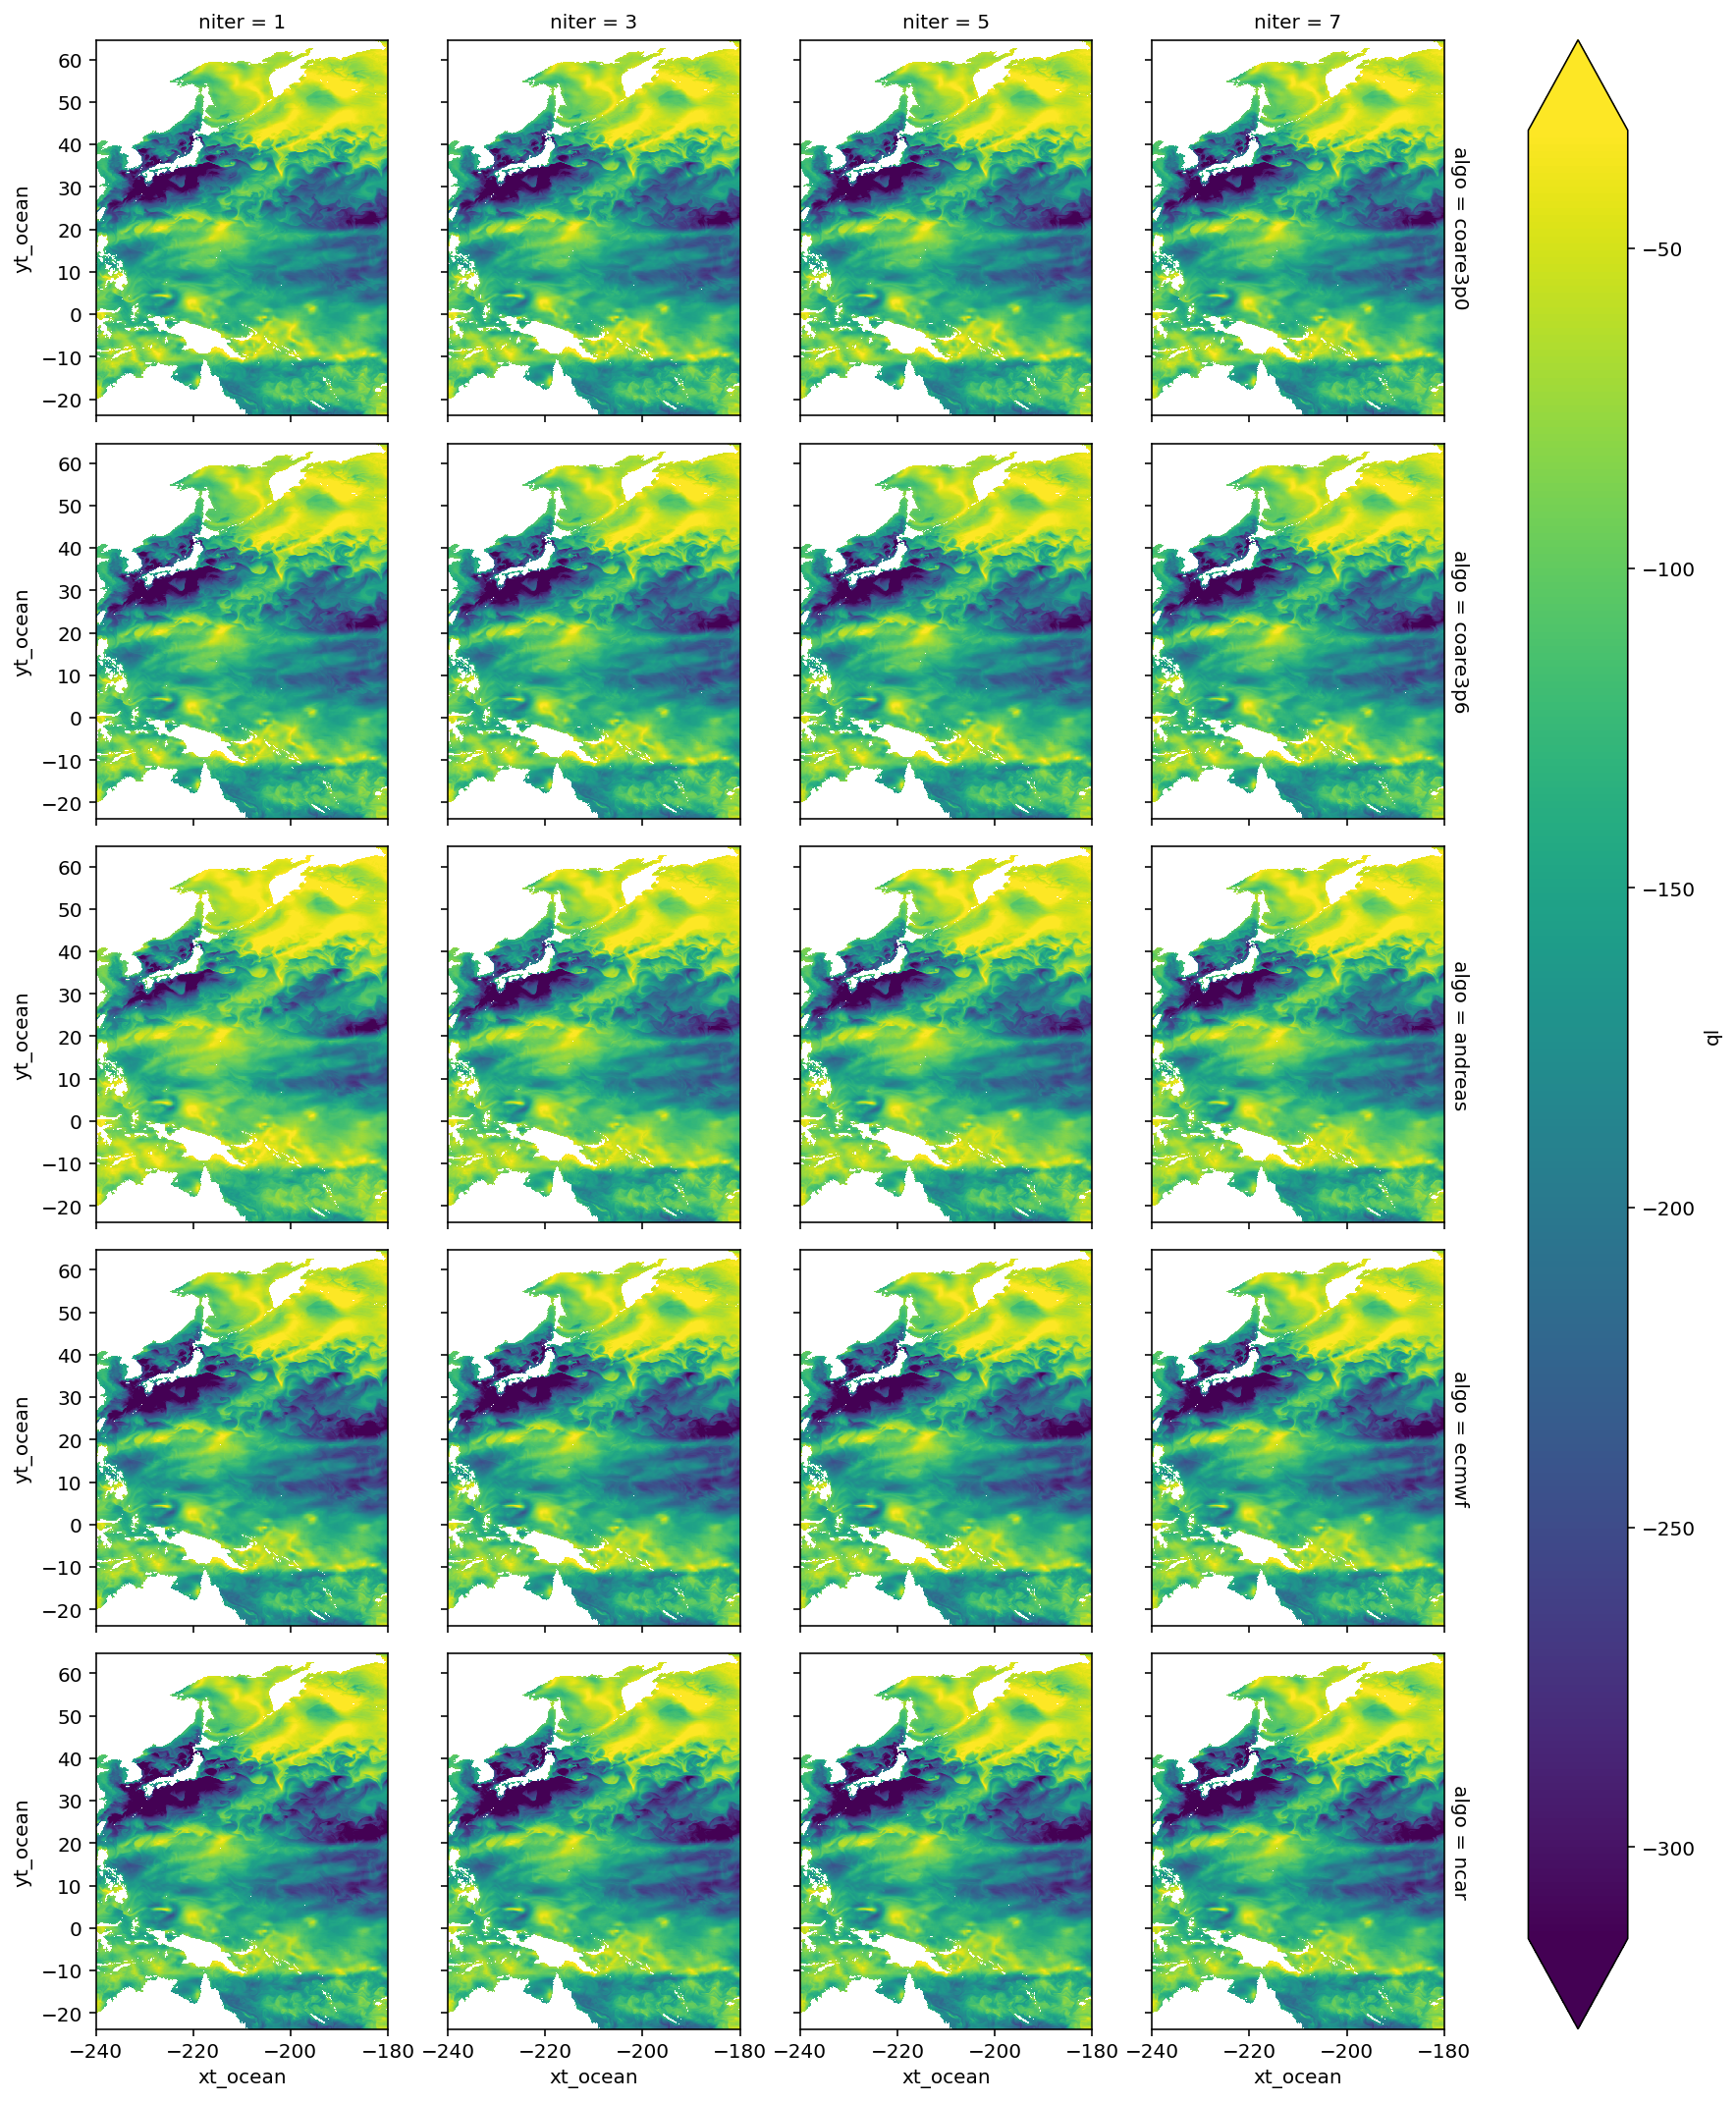

In [25]:
# Lets look at the raw output fields
for va in out_vars:
    ds_output.isel(time=0, niter=[0,2,4,6])[va].plot(col='niter', row='algo', robust=True, x='xt_ocean')
    break

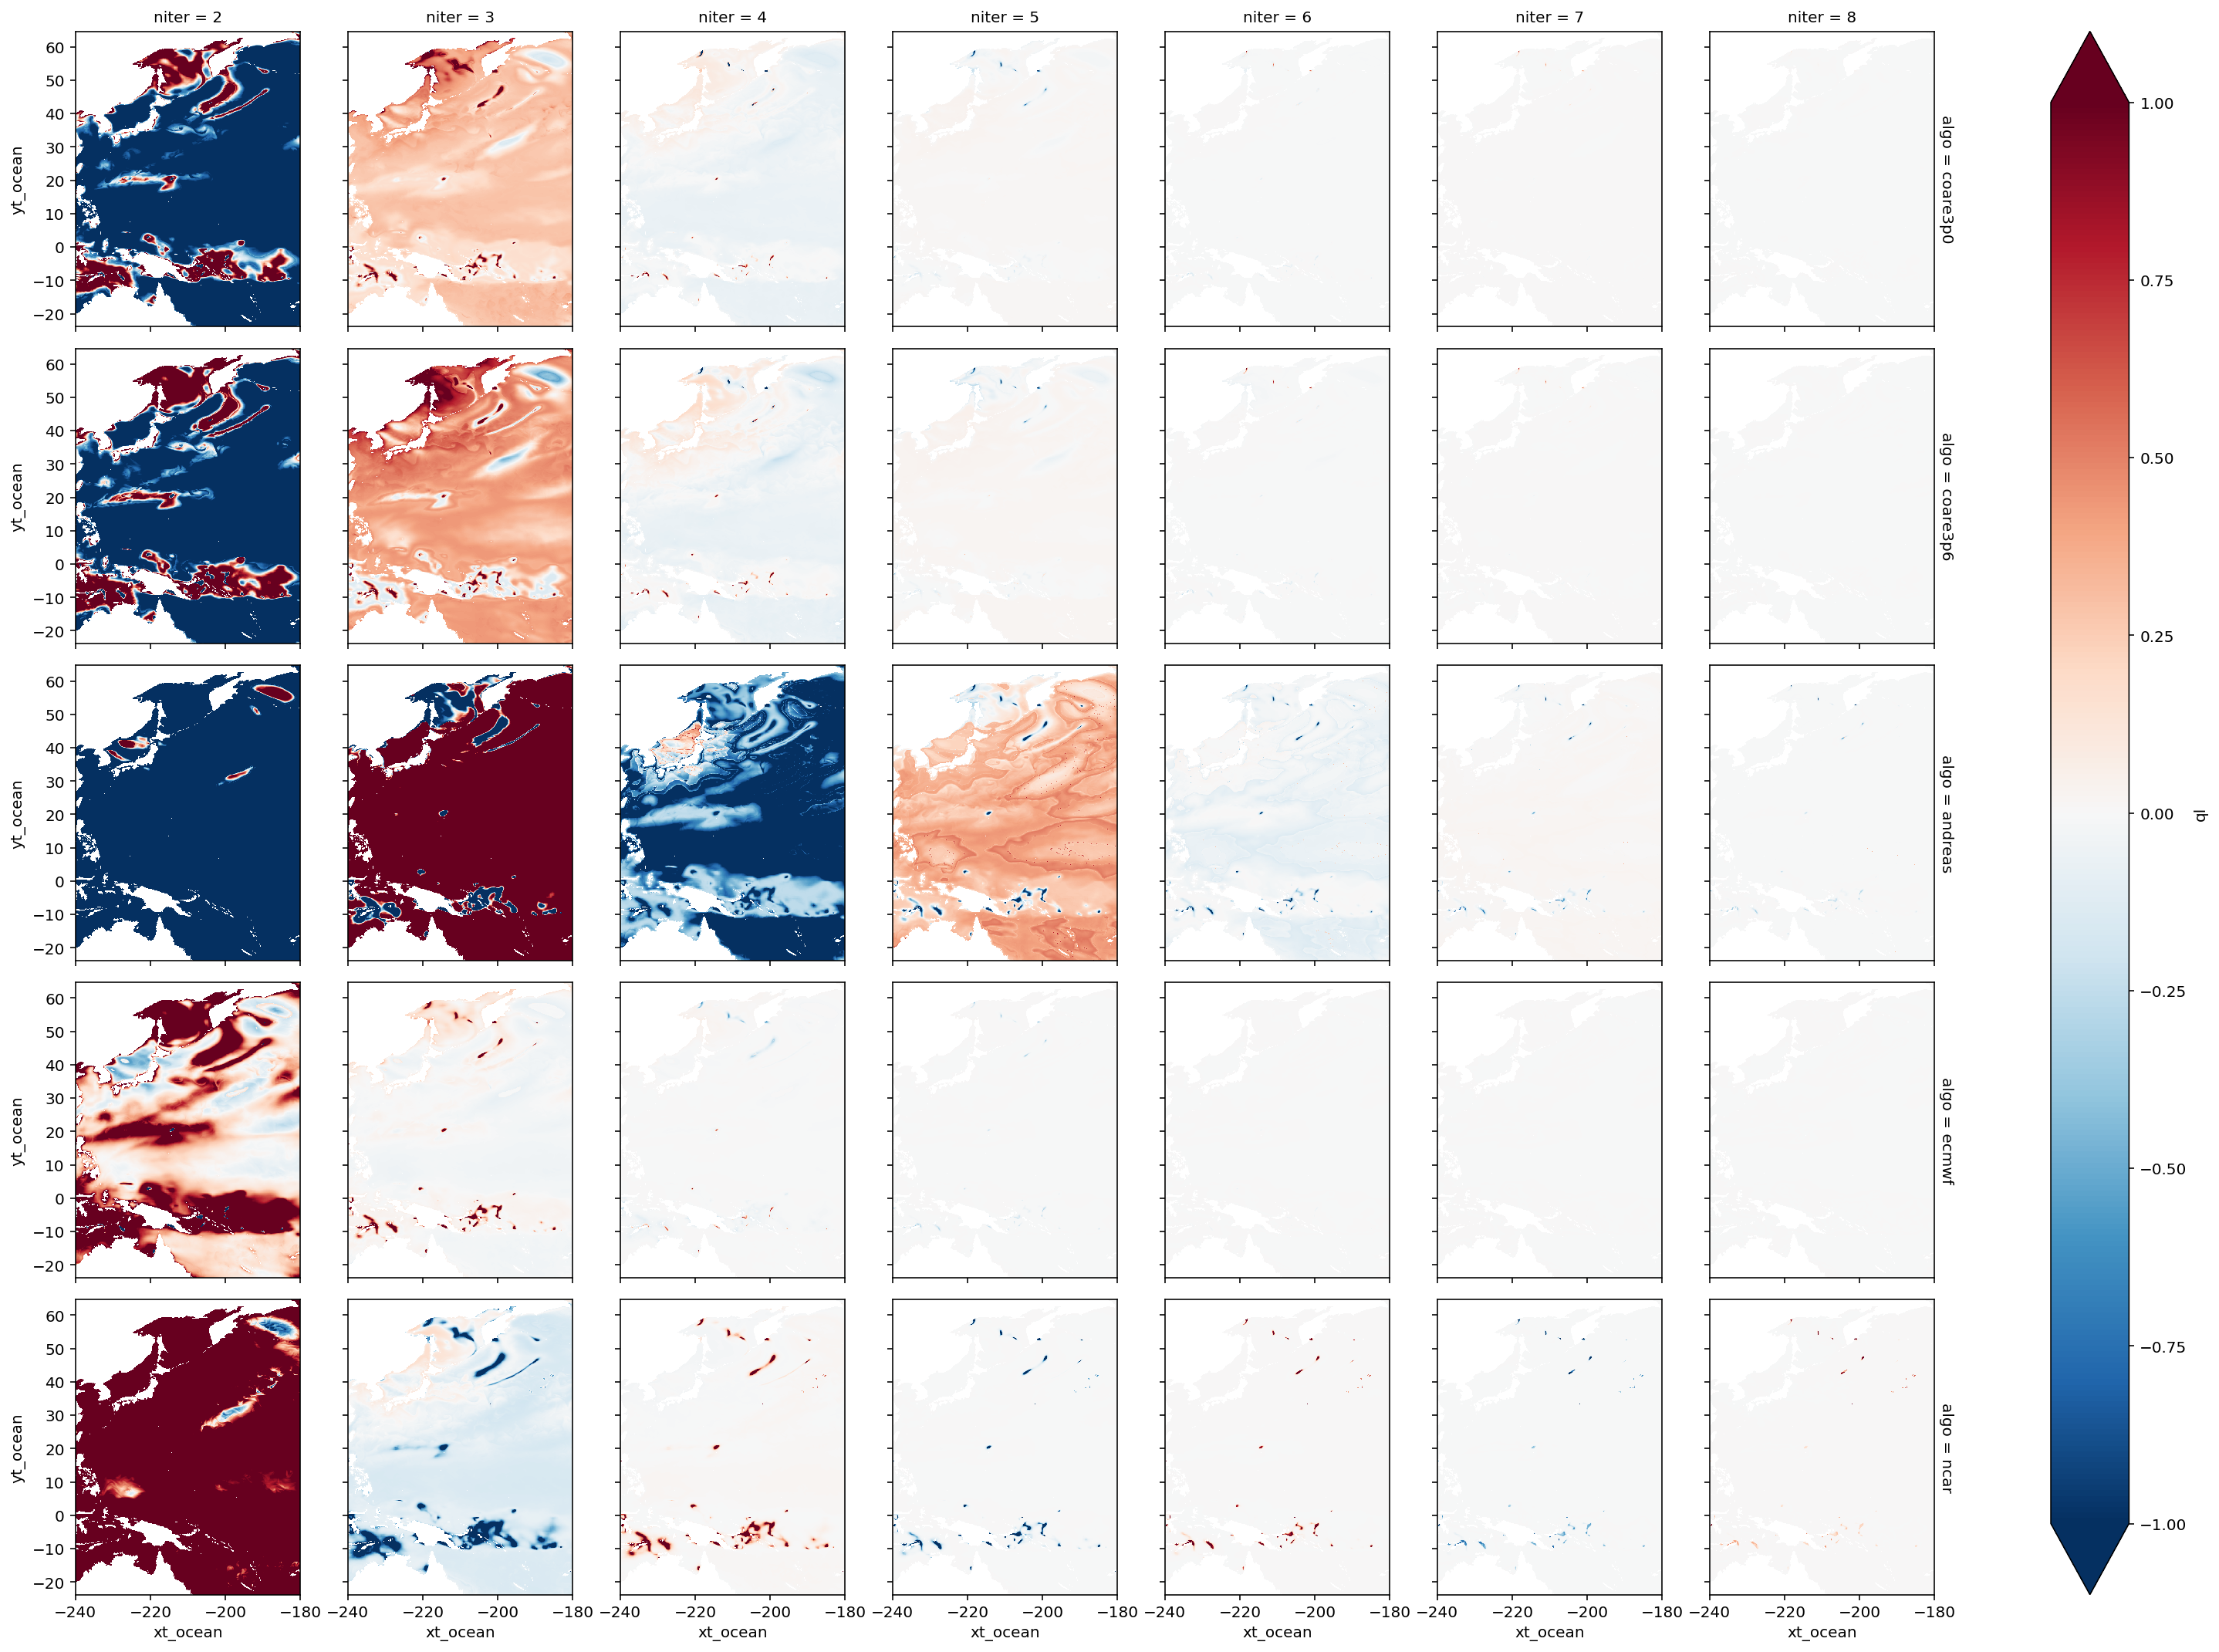

In [26]:
for va in out_vars:
    rel_difference.isel(time=0)[va].plot(col='niter', row='algo', vmax=1, x='xt_ocean')
    break

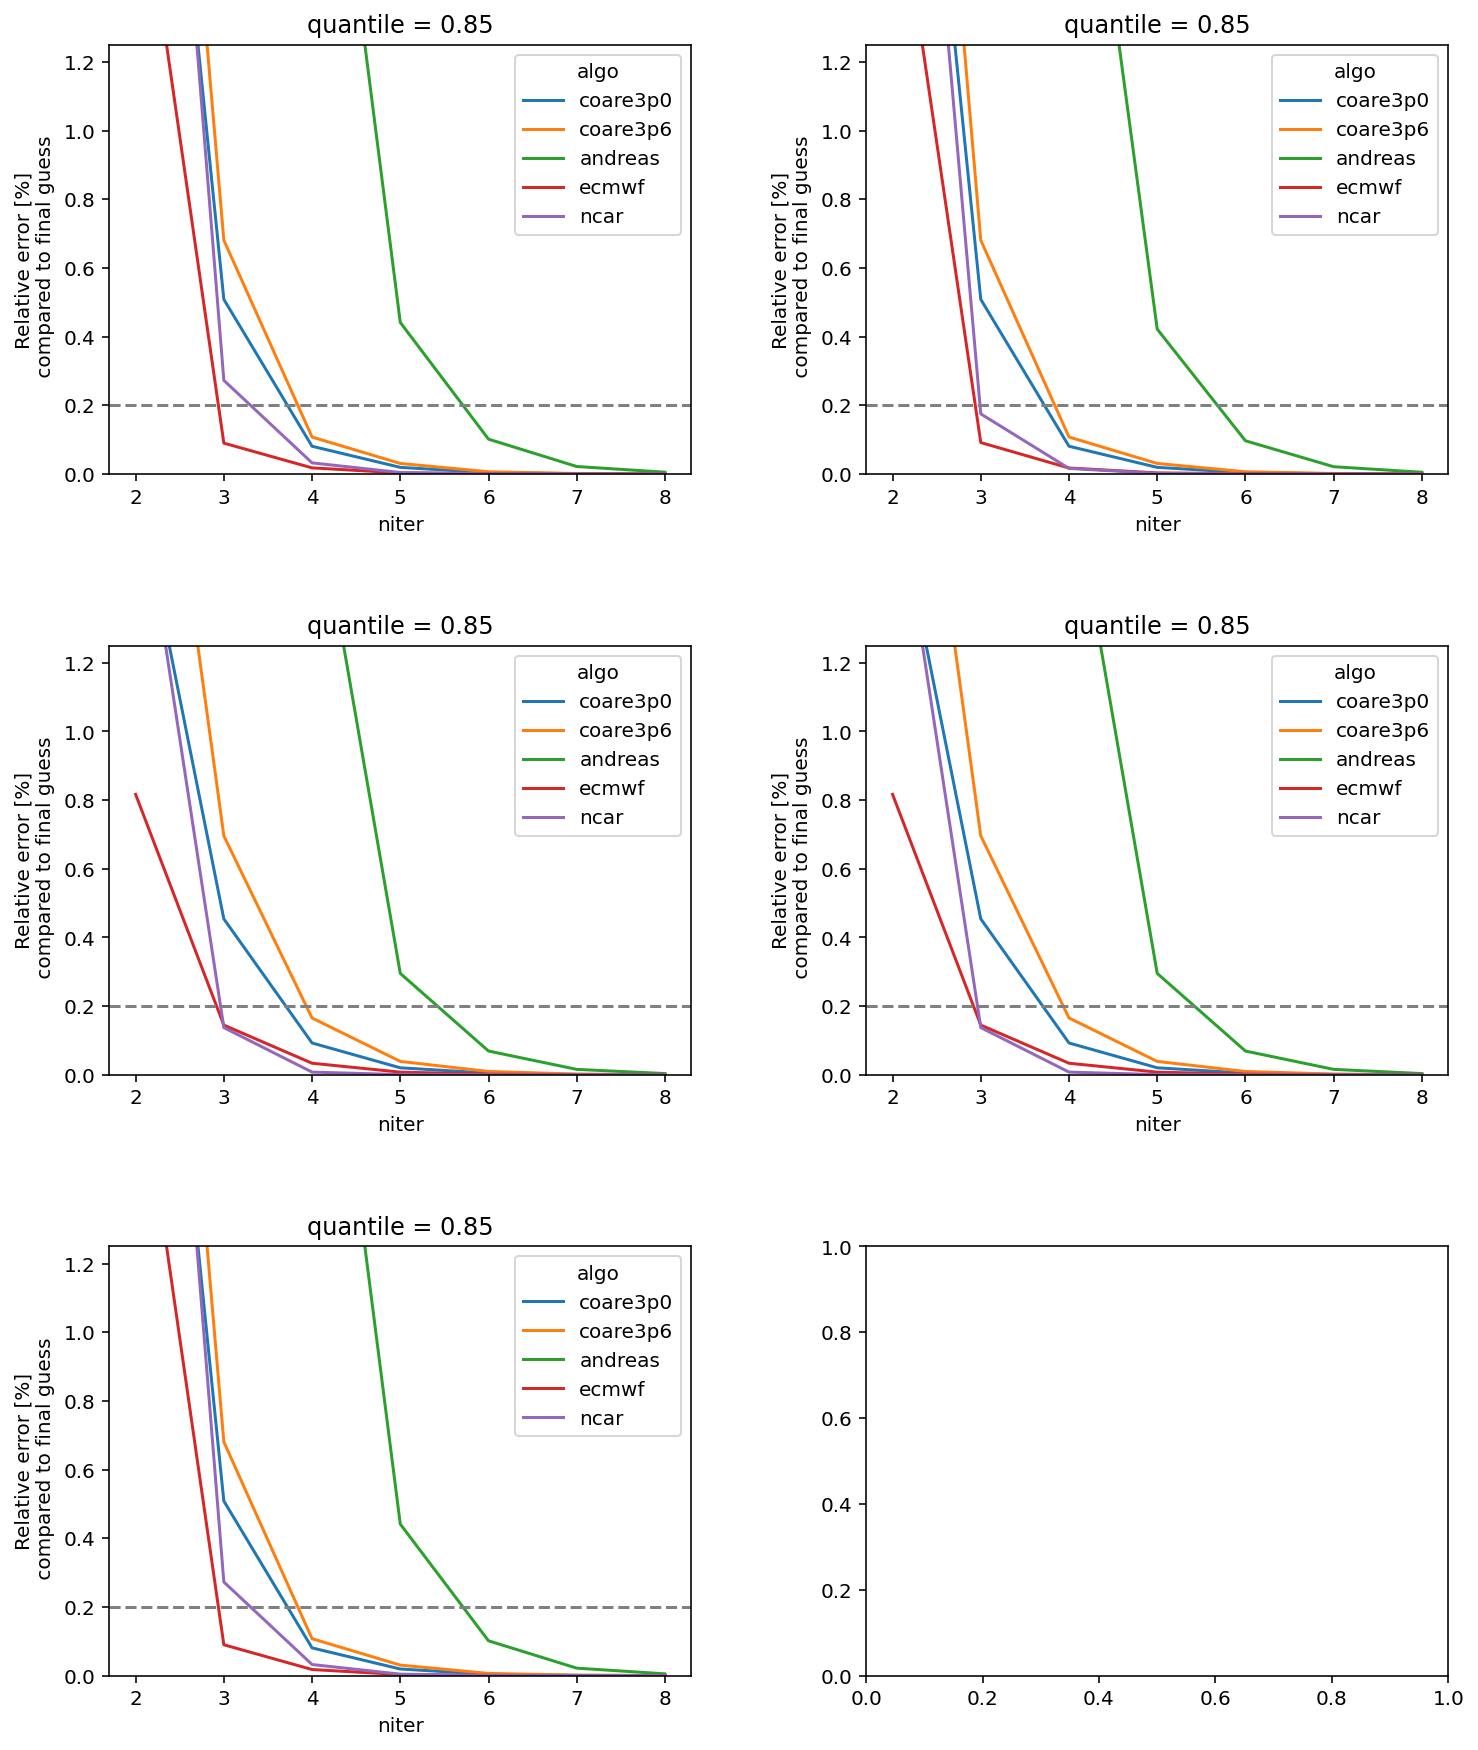

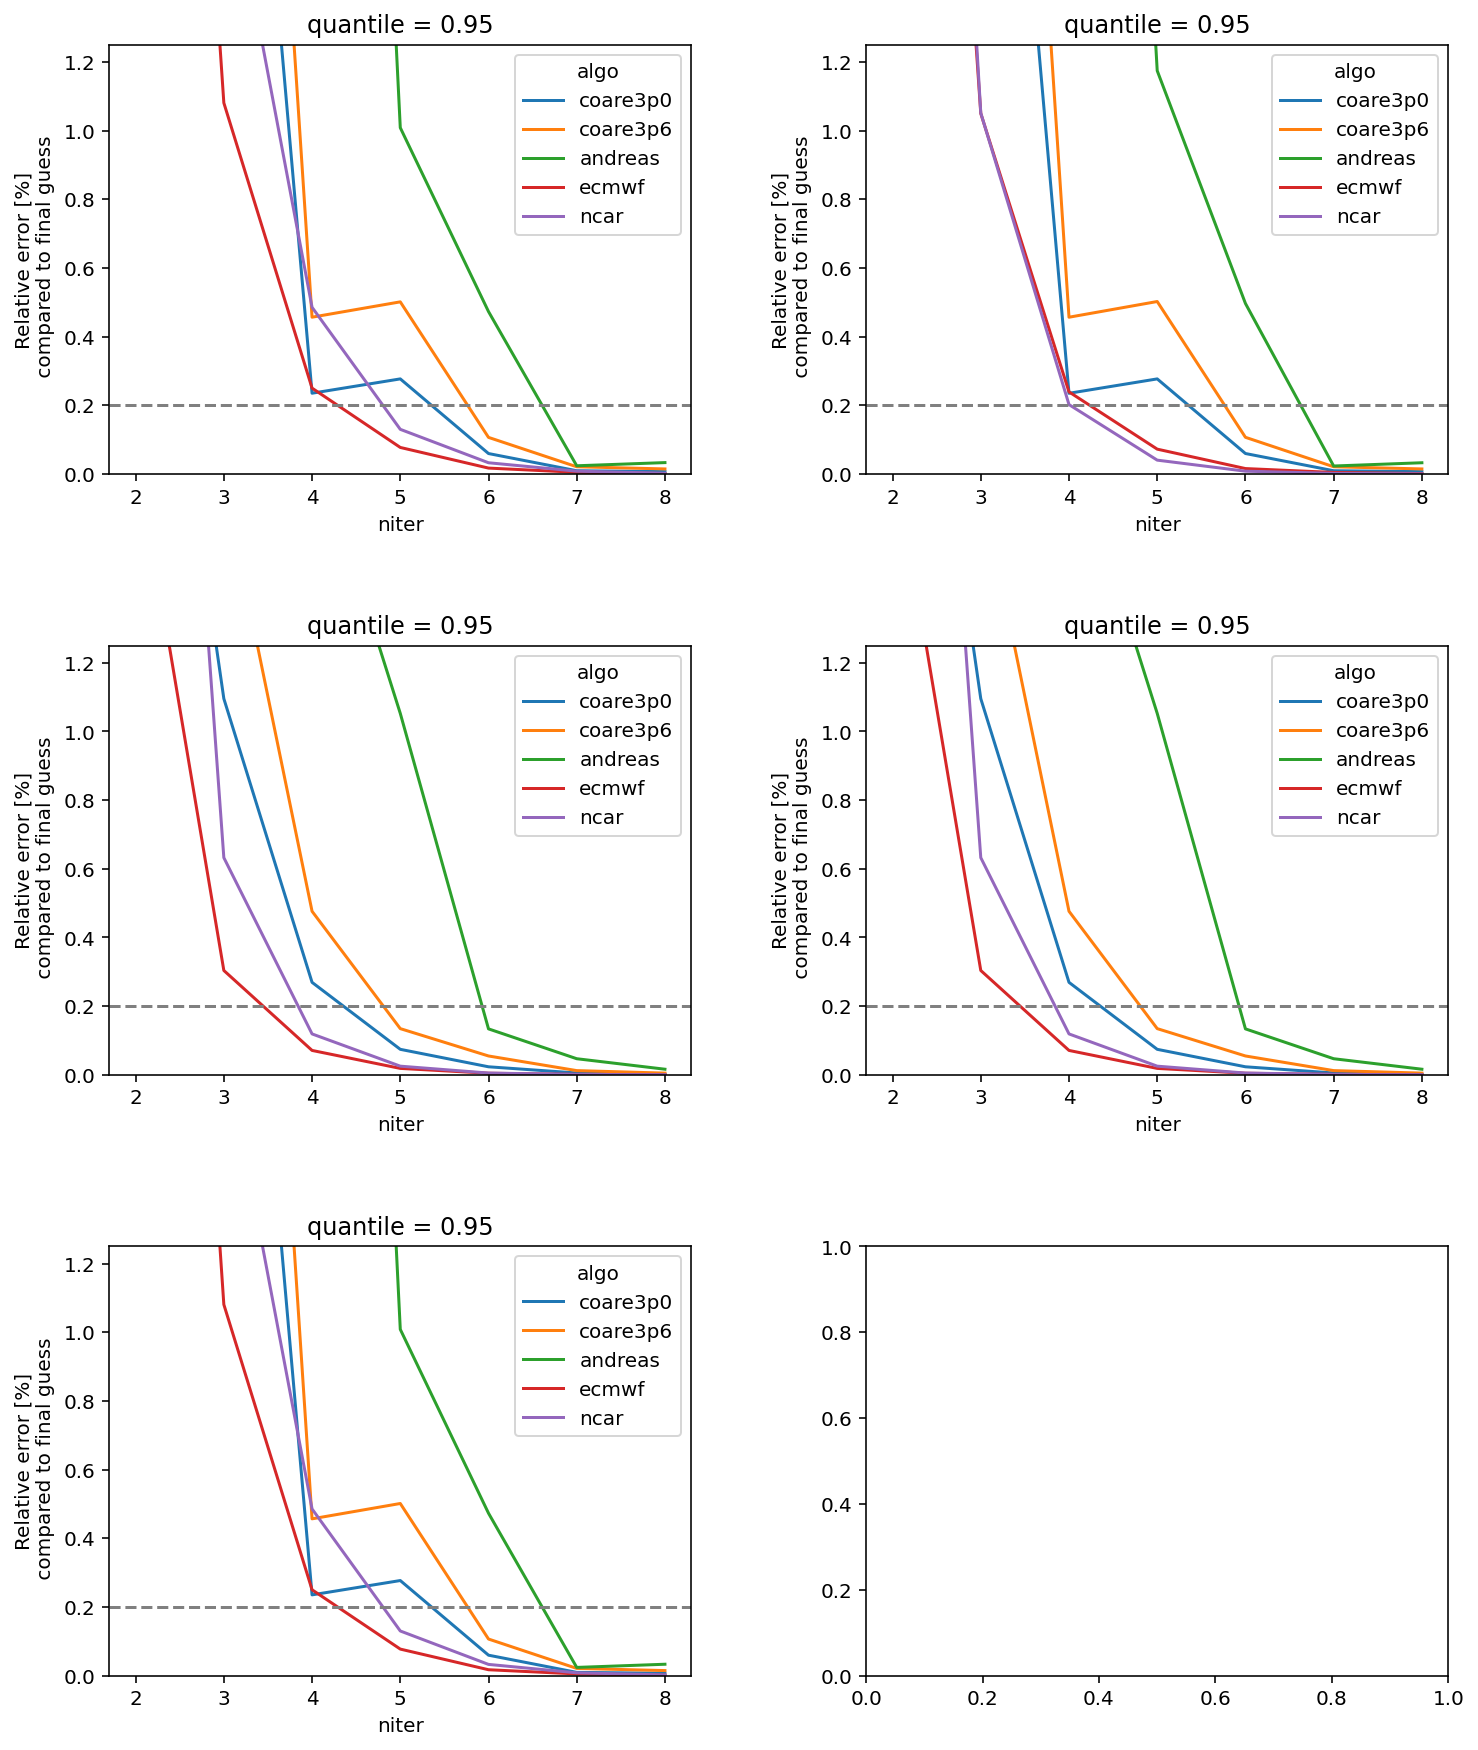

In [24]:
# summarizing statistics
for p in [0.85, 0.95]:
    fig, axarr = plt.subplots(ncols=2, nrows=3, figsize = [12, 15])
    for va, ax in zip(out_vars, axarr.flat):
        pass
        abs(rel_difference[va]).quantile(p, ['xt_ocean', 'yt_ocean', 'time']).plot(x='niter', hue='algo', ax=ax)
        ax.set_ylim(0, 1.25)
        ax.axhline(relative_error_threshold*100, color='0.5', ls='--')
        ax.set_ylabel(f'Relative error [%]\n compared to final guess')
    # fig.suptitle()
    fig.subplots_adjust(hspace=0.4, wspace=0.3)

- I am currently resource limited here. Doing this analysis in memory is not really working, but should be no problem once we have the xarray wrapper working properly
- Seems like niter 5-6 seems like a value that works for a wide range of values. This is however quite large already.